# Sentiment analysis of tweets

Predict whether a tweet is positive, negative or neutral.

In [57]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import ast
import datetime

import re

from nltk.corpus import stopwords

# Stemming
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# cleaning geographical data
import geotext
import nltk

# vectorisor
from sklearn.feature_extraction.text import TfidfVectorizer

# models
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, roc_auc_score, roc_curve

# multiclass
from sklearn.multiclass import OneVsRestClassifier

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

In [9]:
pd.set_option('display.max_rows', None,'max.columns', None,'display.max_colwidth', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [10]:
df = pd.read_csv('Tweets.csv')

df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.349,NaN,0.000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.684,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [11]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [12]:
# There are no missing values in the target column or the predictor variable

In [13]:
# train test split

X = df['text']
y = df['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10)

# Clean all tweets

In [79]:
global stopwords_list  

stopwords_list = stopwords.words('english')

In [86]:
class clean_tweet(BaseEstimator,TransformerMixin):
    
    def __init__(self):
        print('init called')
    
    def fit(self,X,y=None):
        print('fit called')
        return self
       
    def transform(self, X, y = None):
        
        print('transform called')
        
        X_1 = X.copy()
  
        def clean_tweet_func(tweet):

            if type(tweet) == float:
                return ""

            temp = tweet.lower()
            temp = re.sub("'", "", temp) # to avoid removing contractions in english
            temp = re.sub("@[A-Za-z0-9_]+","", temp)
            temp = re.sub("#[A-Za-z0-9_]+","", temp)
            temp = re.sub(r'http\S+', '', temp)
            temp = re.sub('[()!?]', ' ', temp)
            temp = re.sub('\[.*?\]',' ', temp)
            temp = re.sub("[^a-z0-9]"," ", temp)
            temp = temp.split()
            temp = [w for w in temp if not w in stopwords_list]


            #Instantiate stemming class
            stemmer = PorterStemmer()

            #Creating a list of stems of words in tweet
            tweets_stem = []
            for word in temp:
                stem_word = stemmer.stem(word)
                tweets_stem.append(stem_word)

            tweets_stem = " ".join(word for word in tweets_stem)

            return tweets_stem
        
        X_1 = X_1.apply(lambda x: clean_tweet_func(x))
        
        return X_1


In [87]:
# build the pipeline

text_transformer = Pipeline(steps = [('cleaner',clean_tweet()),
                                    ('vectorize_text',TfidfVectorizer(ngram_range=(1,2), max_features=500000))])


init called


In [88]:
# fit the pipeline on train data

text_transformer.fit(X_train)

X_train_text_vectorised = text_transformer.transform(X_train)

fit called
transform called
transform called


In [89]:
# transform the test data with the pipeline

X_test_text_vectorised = text_transformer.transform(X_test)

transform called


In [85]:
# SMOTE on the training data

from imblearn.over_sampling import SMOTE

sm_model = SMOTE()
X_train_res, y_train_res = sm_model.fit_resample(X_train_text_vectorised, y_train) 

In [21]:
y_train_res.value_counts()

negative    7397
positive    7397
neutral     7397
Name: airline_sentiment, dtype: int64

# Predictive Modelling

## Naive Bayes

In [22]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_res, y_train_res)
y_pred_train = BNBmodel.predict(X_train_res)

In [23]:
print(classification_report(y_train_res,y_pred_train))

              precision    recall  f1-score   support

    negative       1.00      0.89      0.94      7397
     neutral       0.85      0.99      0.91      7397
    positive       0.97      0.92      0.94      7397

    accuracy                           0.93     22191
   macro avg       0.94      0.93      0.93     22191
weighted avg       0.94      0.93      0.93     22191



In [24]:
y_pred_test = BNBmodel.predict(X_test_text_vectorised)

naive_bayes_classification_report = classification_report(y_test,y_pred_test, output_dict=True)

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

    negative       0.92      0.69      0.79      1781
     neutral       0.50      0.79      0.61       680
    positive       0.61      0.68      0.64       467

    accuracy                           0.71      2928
   macro avg       0.68      0.72      0.68      2928
weighted avg       0.77      0.71      0.72      2928



<AxesSubplot:>

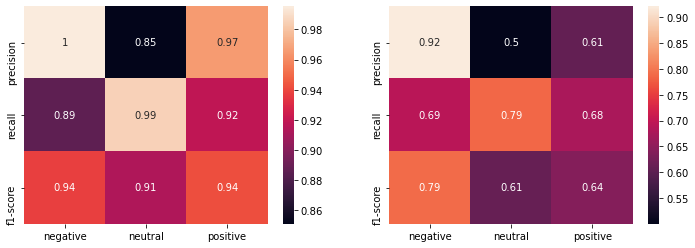

In [25]:
# train results

plt.figure(figsize = (12,4))

plt.subplot(1,2,1)

sns.heatmap(pd.DataFrame(classification_report(y_train_res,y_pred_train, output_dict= True)).iloc[:3,:3], annot= True)


# test results
plt.subplot(1,2,2)

sns.heatmap(pd.DataFrame(classification_report(y_test,y_pred_test, output_dict= True)).iloc[:3,:3], annot= True)

Text(0.5, 0, 'Tweet Sentiment')

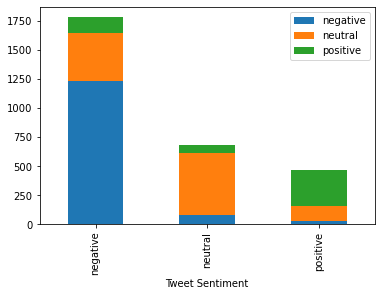

In [26]:
# lets visualise where our missclassified samples are going

pd.DataFrame(confusion_matrix(y_test,y_pred_test), index = ['negative','neutral', 'positive'],columns = ['negative','neutral', 'positive']).plot(kind = 'bar', stacked = True)

plt.xlabel('Tweet Sentiment')

A large chunk of neutral reviews are clasified as negative.

In [27]:
cohen_kappa_score(y_test,y_pred_test)

0.5264628022683961

This indicates moderate agreement.

## Logistic Regression

In [28]:
log_model = LogisticRegression(multi_class='ovr', solver='liblinear')
log_model.fit(X_train_res, y_train_res)
y_pred_train = log_model.predict(X_train_res)

In [29]:
print(classification_report(y_train_res,y_pred_train,zero_division=0))

              precision    recall  f1-score   support

    negative       0.95      0.93      0.94      7397
     neutral       0.86      0.94      0.90      7397
    positive       0.95      0.88      0.91      7397

    accuracy                           0.92     22191
   macro avg       0.92      0.92      0.92     22191
weighted avg       0.92      0.92      0.92     22191



In [30]:
y_pred_test = log_model.predict(X_test_text_vectorised)

log_reg_classification_report = classification_report(y_test,y_pred_test, output_dict=True)

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

    negative       0.83      0.91      0.86      1781
     neutral       0.73      0.51      0.60       680
    positive       0.69      0.73      0.71       467

    accuracy                           0.79      2928
   macro avg       0.75      0.72      0.72      2928
weighted avg       0.78      0.79      0.78      2928



<AxesSubplot:>

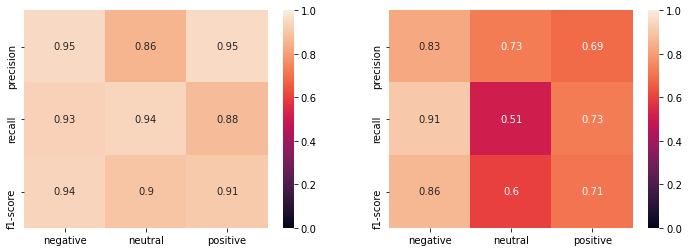

In [31]:
# train results

plt.figure(figsize = (12,4))

plt.subplot(1,2,1)

sns.heatmap(pd.DataFrame(classification_report(y_train_res,y_pred_train, output_dict= True)).iloc[:3,:3], annot= True,vmin=0 ,vmax=1)


# test results
plt.subplot(1,2,2)

sns.heatmap(pd.DataFrame(classification_report(y_test,y_pred_test, output_dict= True)).iloc[:3,:3], annot= True,vmin=0 ,vmax=1)

Text(0.5, 0, 'Tweet Sentiment')

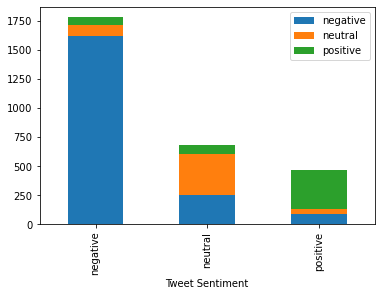

In [32]:
# lets visualise where our missclassified samples are going

pd.DataFrame(confusion_matrix(y_test,y_pred_test), index = ['negative','neutral', 'positive'],columns = ['negative','neutral', 'positive']).plot(kind = 'bar', stacked = True)

plt.xlabel('Tweet Sentiment')

A chunk of negative reviews are clasified as neutral.

In [33]:
cohen_kappa_score(y_test,y_pred_test)

0.5969549791966816

### SVM

In [648]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train_res, y_train_res)
y_pred_train = SVCmodel.predict(X_train_res)

In [649]:
print(classification_report(y_train_res,y_pred_train, zero_division=0))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      7397
     neutral       0.93      0.99      0.96      7397
    positive       0.99      0.93      0.95      7397

    accuracy                           0.97     22191
   macro avg       0.97      0.97      0.97     22191
weighted avg       0.97      0.97      0.97     22191



In [650]:
y_pred_test = SVCmodel.predict(X_test_text_vectorised)

svm_classification_report = classification_report(y_test,y_pred_test, output_dict=True)

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

    negative       0.80      0.93      0.86      1781
     neutral       0.72      0.45      0.56       680
    positive       0.72      0.68      0.70       467

    accuracy                           0.78      2928
   macro avg       0.75      0.69      0.71      2928
weighted avg       0.77      0.78      0.77      2928



<AxesSubplot:>

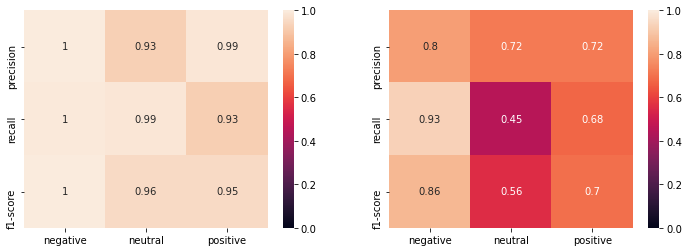

In [613]:
# train results

plt.figure(figsize = (12,4))

plt.subplot(1,2,1)

sns.heatmap(pd.DataFrame(classification_report(y_train_res,y_pred_train, output_dict= True)).iloc[:3,:3], annot= True,vmin=0 ,vmax=1)


# test results
plt.subplot(1,2,2)

sns.heatmap(pd.DataFrame(classification_report(y_test,y_pred_test, output_dict= True)).iloc[:3,:3], annot= True,vmin=0 ,vmax=1)

Text(0.5, 0, 'Tweet Sentiment')

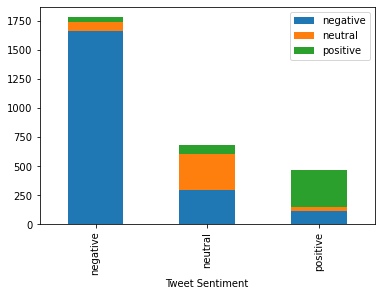

In [614]:
# lets visualise where our missclassified samples are going

pd.DataFrame(confusion_matrix(y_test,y_pred_test), index = ['negative','neutral', 'positive'],columns = ['negative','neutral', 'positive']).plot(kind = 'bar', stacked = True)

plt.xlabel('Tweet Sentiment')

SVM has classified a chunk of the negative class as neutral.

In [615]:
cohen_kappa_score(y_test,y_pred_test)

0.5713275960924296

## Random Forest

In [399]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
rf_model = RandomForestClassifier(max_depth=15, n_estimators = 100)

rf_model.fit(X_train_res, y_train_res)
y_pred_train = rf_model.predict(X_train_res)

In [64]:
print(classification_report(y_train_res,y_pred_train, zero_division=0))

              precision    recall  f1-score   support

    negative       0.87      0.81      0.84      7397
     neutral       0.71      0.83      0.77      7397
    positive       0.87      0.79      0.83      7397

    accuracy                           0.81     22191
   macro avg       0.82      0.81      0.81     22191
weighted avg       0.82      0.81      0.81     22191



In [647]:
y_pred_test = rf_model.predict(X_test_text_vectorised)

rf_classification_report = classification_report(y_test,y_pred_test, output_dict=True)

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

    negative       0.84      0.81      0.82      1781
     neutral       0.56      0.62      0.59       680
    positive       0.66      0.62      0.64       467

    accuracy                           0.74      2928
   macro avg       0.68      0.69      0.68      2928
weighted avg       0.74      0.74      0.74      2928



<AxesSubplot:>

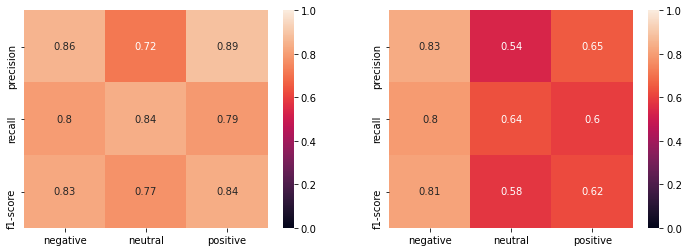

In [619]:
# train results

plt.figure(figsize = (12,4))

plt.subplot(1,2,1)

sns.heatmap(pd.DataFrame(classification_report(y_train_res,y_pred_train, output_dict= True)).iloc[:3,:3], annot= True,vmin=0 ,vmax=1)


# test results
plt.subplot(1,2,2)

sns.heatmap(pd.DataFrame(classification_report(y_test,y_pred_test, output_dict= True)).iloc[:3,:3], annot= True,vmin=0 ,vmax=1)

Text(0.5, 0, 'Tweet Sentiment')

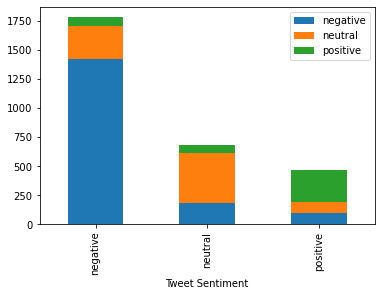

In [620]:
# lets visualise where our missclassified samples are going

pd.DataFrame(confusion_matrix(y_test,y_pred_test), index = ['negative','neutral', 'positive'],columns = ['negative','neutral', 'positive']).plot(kind = 'bar', stacked = True)

plt.xlabel('Tweet Sentiment')

A large chunk of neutral reviews are clasified as negative.

In [621]:
cohen_kappa_score(y_test,y_pred_test)

0.5117125748802198

# Visualise all model results

In [653]:
results = pd.DataFrame([naive_bayes_classification_report['weighted avg'],
             log_reg_classification_report['weighted avg'],
             svm_classification_report['weighted avg'],
             rf_classification_report['weighted avg']],index = ['naive_bayes',
                                                                      'logistic_regression',
                                                                      'svm', 'rf'])

Text(0, 0.5, 'Weighted Average Score')

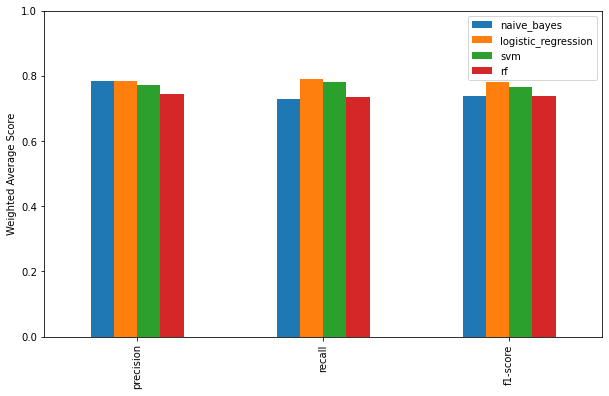

In [665]:
results.iloc[:,:3].transpose().plot(kind = 'bar',figsize = (10,6))

plt.ylim([0,1])

plt.ylabel('Weighted Average Score')

# Logistic Regression 

### Reducing Overfit

In [36]:
log_model_1 = LogisticRegression(multi_class='ovr', solver='liblinear',random_state = 10)

log_model_1.fit(X_train_res, y_train_res)

y_pred_train = log_model_1.predict(X_train_res)

print(classification_report(y_train_res,y_pred_train,zero_division=0))

              precision    recall  f1-score   support

    negative       0.95      0.93      0.94      7397
     neutral       0.86      0.94      0.90      7397
    positive       0.95      0.88      0.91      7397

    accuracy                           0.92     22191
   macro avg       0.92      0.92      0.92     22191
weighted avg       0.92      0.92      0.92     22191



In [37]:
y_pred_test = log_model_1.predict(X_test_text_vectorised)

log_reg_1_classification_report = classification_report(y_test,y_pred_test, output_dict=True)

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

    negative       0.83      0.91      0.86      1781
     neutral       0.73      0.51      0.60       680
    positive       0.69      0.73      0.71       467

    accuracy                           0.79      2928
   macro avg       0.75      0.72      0.72      2928
weighted avg       0.78      0.79      0.78      2928



In [38]:
y_text_proba = log_model_1.predict_proba(X_test_text_vectorised)

print(roc_auc_score(y_test,y_text_proba,multi_class='ovr'))

0.8911259983761073


In [39]:
n_classes = 3

# classifier
clf = OneVsRestClassifier(log_model_1)
y_score = clf.fit(X_train_res, y_train_res).decision_function(X_test_text_vectorised)

y_score[:5]

array([[ 1.65358619, -2.50490237, -2.56109242],
       [-2.23044689, -0.40795621, -1.1050261 ],
       [ 0.47486558, -2.42870889, -0.58919544],
       [ 3.64220621, -3.89969696, -3.29407306],
       [ 3.74312583, -3.24625104, -3.66043942]])

No handles with labels found to put in legend.


negative


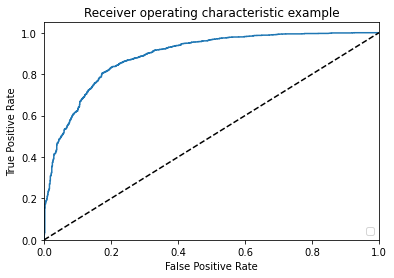

No handles with labels found to put in legend.


neutral


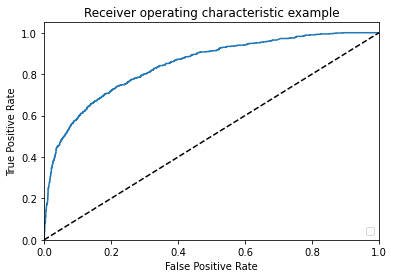

No handles with labels found to put in legend.


positive


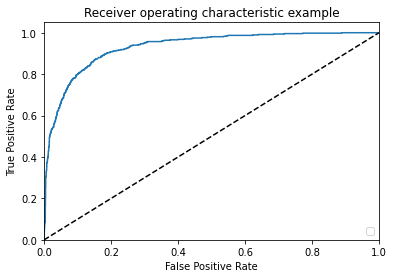

In [40]:
n_classes = 3

# classifier
clf = OneVsRestClassifier(log_model_1)
y_score = clf.fit(X_train_res, y_train_res).decision_function(X_test_text_vectorised)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# calculate dummies once
y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
for i in range(n_classes):
    fpr[i], tpr[i], thresh = roc_curve(y_test_dummies[:, i], y_score[:, i])
        
        
class_names = ['negative','neutral','positive']

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    print(class_names[i])
    plt.show()

In [41]:
log_model_1.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 10,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [42]:
# grid search

param_grid = [
    {
#     'l1_ratio' : [0.001,0.1,0.2,0.4,0.6,0.8,1],
    'C' : np.logspace(-4, 4, 20)}]

# Create grid search object

grid_model = GridSearchCV(log_model_1, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

grid_model.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='ovr', random_state=10,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}],
             verbose=True)

In [43]:
grid_model.best_params_

{'C': 545.5594781168514}

Lasso 

In [47]:
log_model_2 = LogisticRegression(multi_class='ovr', solver='liblinear',random_state = 10,penalty='l1')

log_model_2.fit(X_train_res, y_train_res)

y_pred_train = log_model_2.predict(X_train_res)

print(classification_report(y_train_res,y_pred_train))

              precision    recall  f1-score   support

    negative       0.86      0.83      0.85      7397
     neutral       0.74      0.85      0.80      7397
    positive       0.89      0.79      0.84      7397

    accuracy                           0.83     22191
   macro avg       0.83      0.83      0.83     22191
weighted avg       0.83      0.83      0.83     22191



In [48]:
y_pred_test = log_model_2.predict(X_test_text_vectorised)

log_reg_1_classification_report = classification_report(y_test,y_pred_test, output_dict=True)

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

    negative       0.84      0.87      0.85      1781
     neutral       0.66      0.55      0.60       680
    positive       0.64      0.73      0.69       467

    accuracy                           0.77      2928
   macro avg       0.72      0.72      0.71      2928
weighted avg       0.77      0.77      0.77      2928



Lasso 

In [51]:
# grid search

param_grid = [
    {
     'l1_ratio' : [0.001,0.01,0.1,0.2,0.4,0.6,0.8,1]}]

# Create grid search object
        
log_model_grid = LogisticRegression(multi_class='ovr', solver='saga',random_state = 10,penalty='elasticnet')

grid_model = GridSearchCV(log_model_grid, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

grid_model.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='ovr',
                                          penalty='elasticnet', random_state=10,
                                          solver='saga'),
             n_jobs=-1,
             param_grid=[{'l1_ratio': [0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8,
                                       1]}],
             verbose=True)

In [52]:
grid_model.best_params_

{'l1_ratio': 0.001}

In [53]:
log_model_2 = LogisticRegression(multi_class='ovr', solver='saga',random_state = 10,penalty='elasticnet',
                                l1_ratio=0.001)

log_model_2.fit(X_train_res, y_train_res)

y_pred_train = log_model_2.predict(X_train_res)

print(classification_report(y_train_res,y_pred_train))

              precision    recall  f1-score   support

    negative       0.95      0.93      0.94      7397
     neutral       0.86      0.94      0.90      7397
    positive       0.95      0.88      0.91      7397

    accuracy                           0.92     22191
   macro avg       0.92      0.92      0.92     22191
weighted avg       0.92      0.92      0.92     22191



In [54]:
y_pred_test = log_model_2.predict(X_test_text_vectorised)

log_reg_1_classification_report = classification_report(y_test,y_pred_test, output_dict=True)

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

    negative       0.83      0.91      0.86      1781
     neutral       0.72      0.51      0.60       680
    positive       0.69      0.73      0.71       467

    accuracy                           0.79      2928
   macro avg       0.75      0.71      0.72      2928
weighted avg       0.78      0.79      0.78      2928



# Reducing overfit in random forest

In [68]:
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [6,8,10,12,14,16,18,20,22,24,26,28,30,32]
#int(x) for x in np.linspace(10, 60, num = 11)
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [69]:
rf_model_grid = RandomForestClassifier(n_estimators = 100)


grid_model = GridSearchCV(rf_model_grid, param_grid = random_grid, cv = 3, verbose=3, n_jobs=1)

# Fit on data

grid_model.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 504 candidates, totalling 1512 fits
[CV 1/3] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.669 total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.759 total time=   1.3s
[CV 3/3] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.766 total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.658 total time=   1.1s
[CV 2/3] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.716 total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.774 total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10;, score=0.654 total time=   1.

[CV 2/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10;, score=0.775 total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10;, score=0.737 total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=2;, score=0.654 total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=2;, score=0.781 total time=   1.7s
[CV 3/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=2;, score=0.782 total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=5;, score=0.628 total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=5;, score=0.737 total time=   1.7s
[CV 3/3] END bootstrap=True, max_depth=8, max_features=auto,

[CV 3/3] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5;, score=0.783 total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10;, score=0.660 total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10;, score=0.783 total time=   2.0s
[CV 3/3] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10;, score=0.786 total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2;, score=0.629 total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2;, score=0.771 total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2;, score=0.776 total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=10, max_featu

[CV 1/3] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=4, min_samples_split=5;, score=0.650 total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=4, min_samples_split=5;, score=0.775 total time=   2.3s
[CV 3/3] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=4, min_samples_split=5;, score=0.783 total time=   2.2s
[CV 1/3] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=4, min_samples_split=10;, score=0.652 total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=4, min_samples_split=10;, score=0.776 total time=   2.3s
[CV 3/3] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=4, min_samples_split=10;, score=0.789 total time=   2.2s
[CV 1/3] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.678 total time=   2.1s
[CV 2/3] END bootstrap=True, max_depth=12, max_featu

[CV 2/3] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.799 total time=   3.2s
[CV 3/3] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.820 total time=   3.0s
[CV 1/3] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=5;, score=0.697 total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=5;, score=0.798 total time=   3.0s
[CV 3/3] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=5;, score=0.805 total time=   3.0s
[CV 1/3] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10;, score=0.683 total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10;, score=0.819 total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=14, max_featur

[CV 3/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10;, score=0.807 total time=   3.2s
[CV 1/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=0.641 total time=   2.5s
[CV 2/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=0.789 total time=   3.1s
[CV 3/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=0.795 total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.663 total time=   2.5s
[CV 2/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.787 total time=   3.1s
[CV 3/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.781 total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=16, max_feature

[CV 1/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=2, min_samples_split=10;, score=0.663 total time=   2.8s
[CV 2/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=2, min_samples_split=10;, score=0.793 total time=   3.4s
[CV 3/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=2, min_samples_split=10;, score=0.797 total time=   3.2s
[CV 1/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=4, min_samples_split=2;, score=0.638 total time=   2.7s
[CV 2/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=4, min_samples_split=2;, score=0.789 total time=   3.3s
[CV 3/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=4, min_samples_split=2;, score=0.786 total time=   3.1s
[CV 1/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=4, min_samples_split=5;, score=0.669 total time=   2.7s
[CV 2/3] END bootstrap=True, max_depth=18, max_featu

[CV 2/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5;, score=0.781 total time=   3.6s
[CV 3/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5;, score=0.791 total time=   3.4s
[CV 1/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10;, score=0.669 total time=   3.0s
[CV 2/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10;, score=0.783 total time=   3.7s
[CV 3/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10;, score=0.786 total time=   3.4s
[CV 1/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.694 total time=   4.1s
[CV 2/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.824 total time=   5.2s
[CV 3/3] END bootstrap=True, max_depth=22, max_featu

[CV 3/3] END bootstrap=True, max_depth=24, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.829 total time=   5.5s
[CV 1/3] END bootstrap=True, max_depth=24, max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.718 total time=   4.3s
[CV 2/3] END bootstrap=True, max_depth=24, max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.833 total time=   5.5s
[CV 3/3] END bootstrap=True, max_depth=24, max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.838 total time=   5.2s
[CV 1/3] END bootstrap=True, max_depth=24, max_features=auto, min_samples_leaf=1, min_samples_split=10;, score=0.714 total time=   4.3s
[CV 2/3] END bootstrap=True, max_depth=24, max_features=auto, min_samples_leaf=1, min_samples_split=10;, score=0.825 total time=   5.3s
[CV 3/3] END bootstrap=True, max_depth=24, max_features=auto, min_samples_leaf=1, min_samples_split=10;, score=0.825 total time=   4.9s
[CV 1/3] END bootstrap=True, max_depth=24, max_featu

[CV 1/3] END bootstrap=True, max_depth=26, max_features=auto, min_samples_leaf=2, min_samples_split=2;, score=0.673 total time=   3.9s
[CV 2/3] END bootstrap=True, max_depth=26, max_features=auto, min_samples_leaf=2, min_samples_split=2;, score=0.807 total time=   4.9s
[CV 3/3] END bootstrap=True, max_depth=26, max_features=auto, min_samples_leaf=2, min_samples_split=2;, score=0.808 total time=   4.6s
[CV 1/3] END bootstrap=True, max_depth=26, max_features=auto, min_samples_leaf=2, min_samples_split=5;, score=0.680 total time=   3.9s
[CV 2/3] END bootstrap=True, max_depth=26, max_features=auto, min_samples_leaf=2, min_samples_split=5;, score=0.801 total time=   4.8s
[CV 3/3] END bootstrap=True, max_depth=26, max_features=auto, min_samples_leaf=2, min_samples_split=5;, score=0.808 total time=   4.6s
[CV 1/3] END bootstrap=True, max_depth=26, max_features=auto, min_samples_leaf=2, min_samples_split=10;, score=0.684 total time=   3.9s
[CV 2/3] END bootstrap=True, max_depth=26, max_feature

[CV 2/3] END bootstrap=True, max_depth=28, max_features=auto, min_samples_leaf=2, min_samples_split=10;, score=0.799 total time=   5.1s
[CV 3/3] END bootstrap=True, max_depth=28, max_features=auto, min_samples_leaf=2, min_samples_split=10;, score=0.813 total time=   4.8s
[CV 1/3] END bootstrap=True, max_depth=28, max_features=auto, min_samples_leaf=4, min_samples_split=2;, score=0.678 total time=   4.0s
[CV 2/3] END bootstrap=True, max_depth=28, max_features=auto, min_samples_leaf=4, min_samples_split=2;, score=0.787 total time=   4.9s
[CV 3/3] END bootstrap=True, max_depth=28, max_features=auto, min_samples_leaf=4, min_samples_split=2;, score=0.802 total time=   4.6s
[CV 1/3] END bootstrap=True, max_depth=28, max_features=auto, min_samples_leaf=4, min_samples_split=5;, score=0.669 total time=   4.0s
[CV 2/3] END bootstrap=True, max_depth=28, max_features=auto, min_samples_leaf=4, min_samples_split=5;, score=0.805 total time=   4.9s
[CV 3/3] END bootstrap=True, max_depth=28, max_featur

[CV 3/3] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5;, score=0.799 total time=   4.9s
[CV 1/3] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10;, score=0.658 total time=   4.2s
[CV 2/3] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10;, score=0.794 total time=   5.2s
[CV 3/3] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10;, score=0.802 total time=   4.9s
[CV 1/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.730 total time=   5.9s
[CV 2/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.839 total time=   7.7s
[CV 3/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.838 total time=   7.1s
[CV 1/3] END bootstrap=True, max_depth=30, max_featu

[CV 1/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=5;, score=0.730 total time=   6.0s
[CV 2/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=5;, score=0.831 total time=   7.5s
[CV 3/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=5;, score=0.848 total time=   7.1s
[CV 1/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=10;, score=0.733 total time=   5.8s
[CV 2/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=10;, score=0.837 total time=   7.2s
[CV 3/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=10;, score=0.838 total time=   6.7s
[CV 1/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=0.679 total time=   4.7s
[CV 2/3] END bootstrap=True, max_depth=32, max_featu

[CV 2/3] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=0.760 total time=   1.8s
[CV 3/3] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=0.730 total time=   1.7s
[CV 1/3] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.652 total time=   1.5s
[CV 2/3] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.763 total time=   1.8s
[CV 3/3] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.770 total time=   1.7s
[CV 1/3] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=10;, score=0.625 total time=   1.4s
[CV 2/3] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=10;, score=0.752 total time=   1.8s
[CV 3/3] END bootstrap=False, max_depth=6, max_featur

[CV 3/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=10;, score=0.748 total time=   2.3s
[CV 1/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=2;, score=0.655 total time=   1.9s
[CV 2/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=2;, score=0.765 total time=   2.4s
[CV 3/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=2;, score=0.780 total time=   2.2s
[CV 1/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=5;, score=0.662 total time=   1.9s
[CV 2/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=5;, score=0.760 total time=   2.3s
[CV 3/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=5;, score=0.770 total time=   2.2s
[CV 1/3] END bootstrap=False, max_depth=8, max_feature

[CV 1/3] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10;, score=0.656 total time=   2.4s
[CV 2/3] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10;, score=0.777 total time=   2.9s
[CV 3/3] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10;, score=0.775 total time=   2.8s
[CV 1/3] END bootstrap=False, max_depth=12, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.709 total time=   3.1s
[CV 2/3] END bootstrap=False, max_depth=12, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.771 total time=   4.1s
[CV 3/3] END bootstrap=False, max_depth=12, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.802 total time=   3.8s
[CV 1/3] END bootstrap=False, max_depth=12, max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.690 total time=   3.1s
[CV 2/3] END bootstrap=False, max_depth=12, m

[CV 2/3] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.795 total time=   4.6s
[CV 3/3] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.819 total time=   4.4s
[CV 1/3] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=1, min_samples_split=10;, score=0.708 total time=   3.6s
[CV 2/3] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=1, min_samples_split=10;, score=0.804 total time=   4.5s
[CV 3/3] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=1, min_samples_split=10;, score=0.810 total time=   4.3s
[CV 1/3] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=2, min_samples_split=2;, score=0.650 total time=   3.4s
[CV 2/3] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=2, min_samples_split=2;, score=0.783 total time=   4.3s
[CV 3/3] END bootstrap=False, max_depth=14, m

[CV 3/3] END bootstrap=False, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=2;, score=0.807 total time=   4.6s
[CV 1/3] END bootstrap=False, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=5;, score=0.684 total time=   3.8s
[CV 2/3] END bootstrap=False, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=5;, score=0.804 total time=   4.9s
[CV 3/3] END bootstrap=False, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=5;, score=0.812 total time=   4.6s
[CV 1/3] END bootstrap=False, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=10;, score=0.669 total time=   4.0s
[CV 2/3] END bootstrap=False, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=10;, score=0.789 total time=   5.0s
[CV 3/3] END bootstrap=False, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=10;, score=0.788 total time=   4.6s
[CV 1/3] END bootstrap=False, max_depth=16, m

[CV 1/3] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=4, min_samples_split=2;, score=0.674 total time=   4.2s
[CV 2/3] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=4, min_samples_split=2;, score=0.794 total time=   5.1s
[CV 3/3] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=4, min_samples_split=2;, score=0.794 total time=   4.9s
[CV 1/3] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=4, min_samples_split=5;, score=0.679 total time=   4.2s
[CV 2/3] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=4, min_samples_split=5;, score=0.784 total time=   5.1s
[CV 3/3] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=4, min_samples_split=5;, score=0.797 total time=   4.8s
[CV 1/3] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=4, min_samples_split=10;, score=0.637 total time=   4.2s
[CV 2/3] END bootstrap=False, max_depth=18, max

[CV 2/3] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10;, score=0.782 total time=   5.7s
[CV 3/3] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10;, score=0.798 total time=   5.3s
[CV 1/3] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.720 total time=   5.5s
[CV 2/3] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.823 total time=   7.1s
[CV 3/3] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.821 total time=   6.8s
[CV 1/3] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5;, score=0.716 total time=   5.3s
[CV 2/3] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5;, score=0.828 total time=   6.9s
[CV 3/3] END bootstrap=False, max_depth=20, ma

[CV 3/3] END bootstrap=False, max_depth=22, max_features=sqrt, min_samples_leaf=1, min_samples_split=5;, score=0.832 total time=   7.1s
[CV 1/3] END bootstrap=False, max_depth=22, max_features=sqrt, min_samples_leaf=1, min_samples_split=10;, score=0.731 total time=   5.9s
[CV 2/3] END bootstrap=False, max_depth=22, max_features=sqrt, min_samples_leaf=1, min_samples_split=10;, score=0.825 total time=   7.4s
[CV 3/3] END bootstrap=False, max_depth=22, max_features=sqrt, min_samples_leaf=1, min_samples_split=10;, score=0.841 total time=   6.9s
[CV 1/3] END bootstrap=False, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=0.689 total time=   5.3s
[CV 2/3] END bootstrap=False, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=0.801 total time=   6.7s
[CV 3/3] END bootstrap=False, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=0.814 total time=   6.4s
[CV 1/3] END bootstrap=False, max_depth=22, m

[CV 1/3] END bootstrap=False, max_depth=24, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.693 total time=   5.7s
[CV 2/3] END bootstrap=False, max_depth=24, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.799 total time=   7.3s
[CV 3/3] END bootstrap=False, max_depth=24, max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.816 total time=   6.8s
[CV 1/3] END bootstrap=False, max_depth=24, max_features=sqrt, min_samples_leaf=2, min_samples_split=10;, score=0.694 total time=   5.7s
[CV 2/3] END bootstrap=False, max_depth=24, max_features=sqrt, min_samples_leaf=2, min_samples_split=10;, score=0.803 total time=   7.1s
[CV 3/3] END bootstrap=False, max_depth=24, max_features=sqrt, min_samples_leaf=2, min_samples_split=10;, score=0.821 total time=   6.7s
[CV 1/3] END bootstrap=False, max_depth=24, max_features=sqrt, min_samples_leaf=4, min_samples_split=2;, score=0.667 total time=   5.4s
[CV 2/3] END bootstrap=False, max_depth=24, m

[CV 2/3] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=4, min_samples_split=2;, score=0.795 total time=   7.4s
[CV 3/3] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=4, min_samples_split=2;, score=0.801 total time=   6.8s
[CV 1/3] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=4, min_samples_split=5;, score=0.686 total time=   5.9s
[CV 2/3] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=4, min_samples_split=5;, score=0.792 total time=   7.3s
[CV 3/3] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=4, min_samples_split=5;, score=0.794 total time=   6.8s
[CV 1/3] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=4, min_samples_split=10;, score=0.666 total time=   5.9s
[CV 2/3] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=4, min_samples_split=10;, score=0.799 total time=   7.3s
[CV 3/3] END bootstrap=False, max_depth=26, ma

[CV 3/3] END bootstrap=False, max_depth=28, max_features=sqrt, min_samples_leaf=4, min_samples_split=10;, score=0.797 total time=   7.3s
[CV 1/3] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.742 total time=   8.6s
[CV 2/3] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.851 total time=  11.3s
[CV 3/3] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.864 total time=  10.8s
[CV 1/3] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.747 total time=   8.4s
[CV 2/3] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.840 total time=  10.9s
[CV 3/3] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.853 total time=  10.3s
[CV 1/3] END bootstrap=False, max_depth=30, max

[CV 1/3] END bootstrap=False, max_depth=32, max_features=auto, min_samples_leaf=1, min_samples_split=10;, score=0.757 total time=   8.7s
[CV 2/3] END bootstrap=False, max_depth=32, max_features=auto, min_samples_leaf=1, min_samples_split=10;, score=0.840 total time=  11.1s
[CV 3/3] END bootstrap=False, max_depth=32, max_features=auto, min_samples_leaf=1, min_samples_split=10;, score=0.855 total time=  10.4s
[CV 1/3] END bootstrap=False, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=2;, score=0.692 total time=   7.5s
[CV 2/3] END bootstrap=False, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=2;, score=0.828 total time=   9.6s
[CV 3/3] END bootstrap=False, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=2;, score=0.817 total time=   9.0s
[CV 1/3] END bootstrap=False, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=5;, score=0.694 total time=   7.5s
[CV 2/3] END bootstrap=False, max_depth=32, m

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26,
                                       28, 30, 32],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=3)

In [70]:
grid_model.best_params_

{'bootstrap': False,
 'max_depth': 32,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [71]:
grid_model.best_score_

0.8197016808616105

In [76]:
rf_model_1 = RandomForestClassifier(n_estimators=100, bootstrap=False, max_depth=32,
                            max_features='sqrt',min_samples_leaf=1,min_samples_split=2)

rf_model.fit(X_train_res, y_train_res)
y_pred_train = rf_model.predict(X_train_res)

In [77]:
print(classification_report(y_train_res,y_pred_train, zero_division=0))

              precision    recall  f1-score   support

    negative       0.86      0.80      0.83      7397
     neutral       0.72      0.83      0.77      7397
    positive       0.88      0.81      0.84      7397

    accuracy                           0.81     22191
   macro avg       0.82      0.81      0.81     22191
weighted avg       0.82      0.81      0.81     22191



In [78]:
y_pred_test = rf_model.predict(X_test_text_vectorised)

rf_classification_report = classification_report(y_test,y_pred_test, output_dict=True)

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

    negative       0.84      0.78      0.81      1781
     neutral       0.52      0.62      0.57       680
    positive       0.64      0.61      0.63       467

    accuracy                           0.72      2928
   macro avg       0.67      0.67      0.67      2928
weighted avg       0.73      0.72      0.72      2928

